In [49]:
import numpy as np
import pandas as pd

In [50]:
FILE_NAME='sampledata_1.xlsx'
SHEET_NAME='hardpaste'


excel_file = pd.ExcelFile(FILE_NAME)
df = excel_file.parse(SHEET_NAME)

required_columns = ['company', 'gender']
if not all(col in df.columns for col in required_columns):
    print("The sheet must contain 'Company' and 'Gender' columns.")
    exit()
df.head(5)


,attage,issue,planner,policy,gender,birthdate,dod,clm_value,amountband,notification,regioncode,company
0,0-19,2005-09-24,T,PPL113,F,1947-03-17,2007-09-09,95249,A2,2010-01-09,2,Che
1,20-29,2002-09-23,Y,PPL123,M,1959-11-16,2005-07-05,167152,A3,2005-07-05,1,Che
2,30-39,1999-09-24,T,PPL487,M,1955-05-12,2004-01-25,119201,A1,2004-03-25,1,Che
3,0-19,2000-11-18,T,PPL668,M,1965-04-05,2005-06-14,120075,A4,2005-11-14,3,Che
4,60-69,1999-09-02,Y,PPL149,M,1920-01-12,2003-06-03,90272,A5,2005-06-03,2,Che


In [51]:
# Get unique values
companies = df['company'].dropna().unique()
genders = df['gender'].dropna().unique()

# Show options and get valid input from user
def get_valid_index(prompt, options):
    while True:
        print(f"\nSelect a {prompt}:")
        for i, option in enumerate(options, start=1):
            print(f"{i}. {option}")
        try:
            choice = int(input("Enter the number for your choice: "))
            if 1 <= choice <= len(options):
                return choice - 1
            else:
                print(f"Please enter a number between 1 and {len(options)}.")
        except ValueError:
            print("Invalid input. Please enter a number.")

# Get valid choices
company_choice = get_valid_index("Company", companies)
gender_choice = get_valid_index("Gender", genders)

# Get selected values
selected_company = companies[company_choice]
selected_gender = genders[gender_choice]

# Filter the DataFrame
df = df[(df['company'] == selected_company) & (df['gender'] == selected_gender)]

# Display the filtered DataFrame
print(f"\nFiltered data for Company: {selected_company} and Gender: {selected_gender}")
df.head(5)


Select a Company:
1. Che
2. Ind


Enter the number for your choice:  1



Select a Gender:
1. F
2. M


Enter the number for your choice:  2



Filtered data for Company: Che and Gender: M


,attage,issue,planner,policy,gender,birthdate,dod,clm_value,amountband,notification,regioncode,company
1,20-29,2002-09-23,Y,PPL123,M,1959-11-16,2005-07-05,167152,A3,2005-07-05,1,Che
2,30-39,1999-09-24,T,PPL487,M,1955-05-12,2004-01-25,119201,A1,2004-03-25,1,Che
3,0-19,2000-11-18,T,PPL668,M,1965-04-05,2005-06-14,120075,A4,2005-11-14,3,Che
4,60-69,1999-09-02,Y,PPL149,M,1920-01-12,2003-06-03,90272,A5,2005-06-03,2,Che
5,70-79,2014-01-28,Y,PPL842,M,1937-02-08,2016-03-14,192966,A1,2018-04-14,1,Che


In [52]:
# Make a copy of the DataFrame to avoid SettingWithCopyWarning
df_copy = df.copy()

# Ensure 'dod' and 'notification' columns are datetime type
df_copy['dod'] = pd.to_datetime(df_copy['dod'])
df_copy['notification'] = pd.to_datetime(df_copy['notification'])

# Group by 'dod' and 'notification' and sum 'clm_value'
summary_df = (
    df_copy.groupby(['dod', 'notification'], as_index=False)
           .agg(sum_clm_value=('clm_value', 'sum'))
)

# Calculate lag in months (floor the value)
def diff_in_months(end_date, start_date):
    return (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)

summary_df['lag'] = summary_df.apply(lambda row: diff_in_months(row['notification'], row['dod']), axis=1)

# Extract year and month from 'dod'
summary_df['dod_year'] = summary_df['dod'].dt.year
summary_df['dod_month'] = summary_df['dod'].dt.month

summary_df.head(5)

,dod,notification,sum_clm_value,lag,dod_year,dod_month
0,1990-10-07,1992-09-07,134554,23,1990,10
1,2000-07-03,2001-03-03,191645,8,2000,7
2,2002-02-15,2004-06-15,123967,28,2002,2
3,2002-03-28,2004-07-28,89684,28,2002,3
4,2002-09-05,2005-02-05,126316,29,2002,9


In [53]:
# Create a new column for row labels: "dod_year_dod_month"
summary_df['row_label'] = summary_df['dod_year'].astype(str) + "_" + summary_df['dod_month'].astype(str).str.zfill(2)

# Pivot table with rows as 'row_label', columns as 'lag', values as sum_clm_value
triangle = summary_df.pivot_table(
    index='row_label',
    columns='lag',
    values='sum_clm_value',
    aggfunc='sum',
    fill_value=0
)

# Sort rows by year_month (optional, if order matters)
triangle = triangle.sort_index()

# Calculate cumulative sums along columns (axis=1) for the run-off triangle
triangle_cum = triangle.cumsum(axis=1)

# Ensure columns from 0 to 30 exist (fill missing columns with 0)
all_lags = list(range(31))
for lag in all_lags:
    if lag not in triangle_cum.columns:
        triangle_cum[lag] = 0

# Reorder columns to be from 0 to 30
triangle_cum = triangle_cum[all_lags]

triangle_cum

lag,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
row_label,,,,,,,,,,,,,,,,,,,,,
1990_10,0,0,0,0,0,0,0,0,0,0,...,0,0,134554,134554,134554,0,0,134554,134554,0
2000_07,0,0,0,0,0,0,0,0,191645,0,...,0,191645,191645,191645,191645,0,0,191645,191645,0
2002_02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,123967,123967,0
2002_03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,89684,89684,0
2002_09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,108137,108137,0,0,108137,234453,0
2002_11,0,0,0,0,0,0,0,0,0,0,...,0,0,277156,277156,277156,0,0,277156,277156,0
2003_06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,90272,90272,0,0,90272,90272,0
2004_01,0,0,119201,119201,0,119201,119201,0,119201,0,...,0,119201,119201,119201,119201,0,0,119201,119201,0
2005_06,0,0,0,0,0,120075,120075,0,120075,0,...,0,120075,120075,120075,120075,0,0,120075,120075,0


In [54]:
# Initialize a dictionary to store development factors
ldf = {}

# Calculate LDF for each lag step: lag i to i+1
for i in range(30):  # up to lag 29 → 30
    current = triangle_cum[i]
    next_ = triangle_cum[i + 1]

    # Only consider rows where current is > 0 to avoid division by zero
    mask = current > 0
    if mask.sum() > 0:
        factor = (next_[mask] / current[mask]).mean()
    else:
        factor = np.nan  # or 1.0 if you prefer defaulting

    ldf[f"{i}→{i+1}"] = round(factor, 4) if not np.isnan(factor) else None

# Convert to DataFrame for display
ldf_df = pd.DataFrame(list(ldf.items()), columns=['Lag', 'Development Factor'])

ldf_df


,Lag,Development Factor
0,0→1,0.0000
1,1→2,NaN
2,2→3,1.0000
3,3→4,0.0000
4,4→5,NaN
5,5→6,1.0000
6,6→7,0.0000
7,7→8,NaN
8,8→9,0.0000
9,9→10,NaN


In [55]:
# Convert LDF values into a list (ordered from lag 0→1 to 29→30)
ldf_values = [ldf[f"{i}→{i+1}"] for i in range(30)]

# Initialize list to store completion factors in percentage
completion_factors_pct = []

# Loop through lag 0 to 29
for i in range(30):
    product = 1
    for j in range(i, 30):
        factor = ldf_values[j]
        if factor is None or np.isnan(factor):
            product = None
            break
        product *= factor
    pct = round(product * 100, 2) if product is not None else None
    completion_factors_pct.append(pct)

# Create a DataFrame with results
cf_pct_df = pd.DataFrame({
    'Lag': list(range(30)),
    'Completion Factor (%)': completion_factors_pct
})

cf_pct_df.head(5)


,Lag,Completion Factor (%)
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN


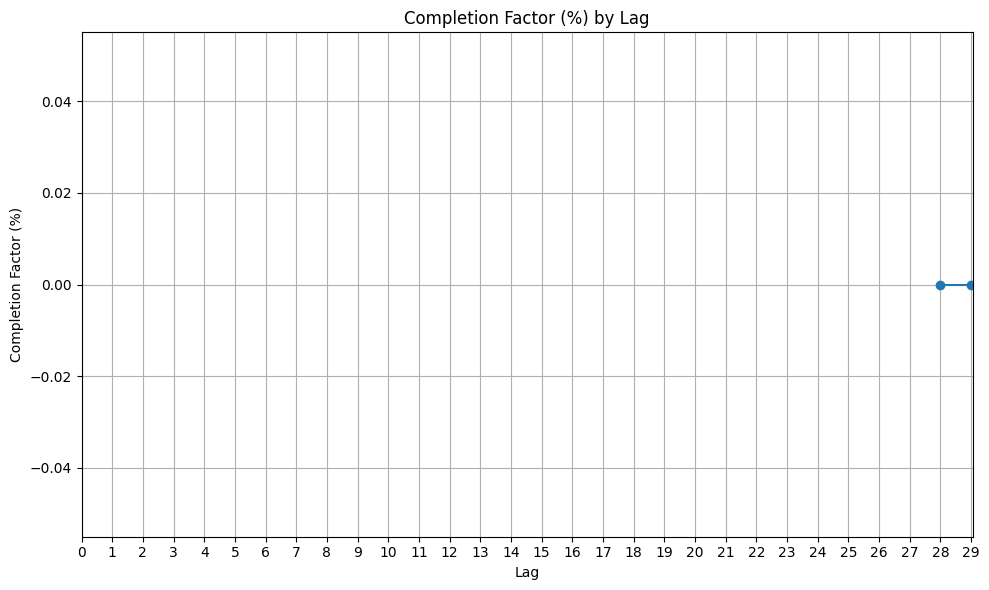

In [56]:
import matplotlib.pyplot as plt

# Plotting the completion factor percentage
plt.figure(figsize=(10, 6))
plt.plot(cf_pct_df['Lag'], cf_pct_df['Completion Factor (%)'], marker='o', linestyle='-')

# Chart formatting
plt.title('Completion Factor (%) by Lag')
plt.xlabel('Lag')
plt.ylabel('Completion Factor (%)')
plt.grid(True)
plt.xticks(range(0, 30, 1))
plt.tight_layout()
plt.show()
